In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from bisect import bisect
import glob
plt.rcParams["figure.figsize"] = (15,15)

In [147]:
path = "data/images/pages/chinese/1000_TsumeGo-10.png"

In [148]:
def to_RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [149]:
def get_edges(img_gray):
    CANNY_THRESHOLD1 = 100
    CANNY_THRESHOLD2 = 200
    return cv2.Canny(img_gray, CANNY_THRESHOLD1, CANNY_THRESHOLD2)

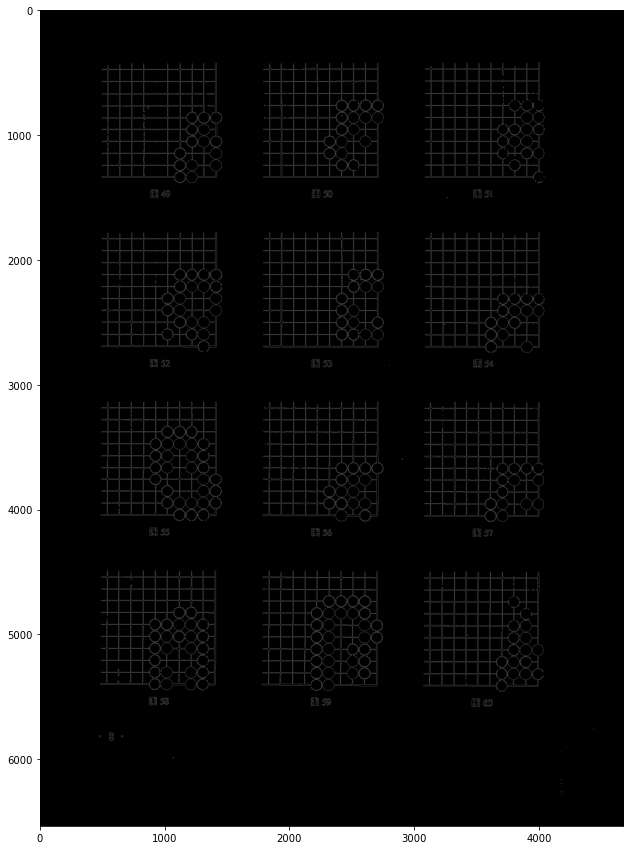

In [150]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
edges = get_edges(img_gray)
plt.imshow(to_RGB(edges))
plt.show() 

In [151]:
def all_lines(img_gray, hough_threshold):
    HOUGH_RHO = 1
    HOUGH_THETA = np.pi/180

    edges = get_edges(img_gray)
    size = min(img_gray.shape[0:2]) 
    lines = cv2.HoughLinesP(edges, rho=HOUGH_RHO, theta=HOUGH_THETA, threshold=hough_threshold,
                            minLineLength=size/2, maxLineGap=size) ### ?
    if lines is None:
        return None
    return np.reshape(lines, (lines.shape[0], lines.shape[2]))

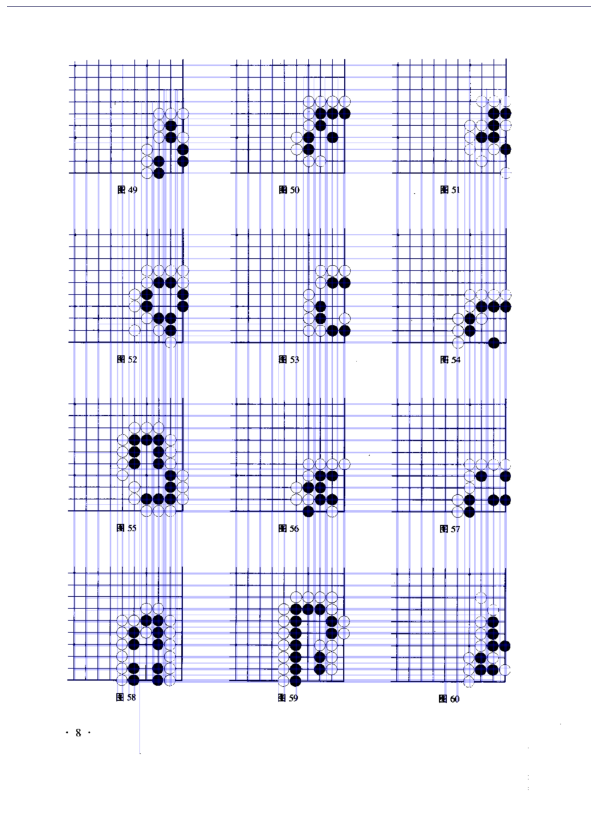

In [152]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
lines = all_lines(img_gray, 200)
img = cv2.imread(path, cv2.IMREAD_COLOR)
for line in lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
plt.imshow(to_RGB(img))
plt.axis('off')
plt.show() 

In [153]:
def get_verticals_horizontals(img_gray, hough_threshold):
    
    VERTICAL_TAN_MIN = 50
    HORIZONTAL_TAN_MAX = 0.02
    
    # Find all lines
    lines = all_lines(img_gray, hough_threshold)
    if (lines is None):
        return [], []
    # Divide the lines into verticals and horizontals
    v_lines = []
    h_lines = []
    for line in lines:
        x1, y1, x2, y2 = line
        if (x1 == x2):
            if (y1 > y2):
                line[0] = x2
                line[1] = y2
                line[2] = x1
                line[3] = y1
            v_lines.append(line)
        else:
            slope = (y2 - y1)/(x2 - x1)
            if (abs(slope) > VERTICAL_TAN_MIN):
                if (y1 > y2):
                    line[0] = x2
                    line[1] = y2
                    line[2] = x1
                    line[3] = y1
            elif (abs(slope) < HORIZONTAL_TAN_MAX):
                if (x1 > x2):
                    line[0] = x2
                    line[1] = y2
                    line[2] = x1
                    line[3] = y1
                h_lines.append(line)
    v_lines = np.array(v_lines)
    h_lines = np.array(h_lines)
    # Merge close lines
    return merge_lines(v_lines, True), merge_lines(h_lines, False)

In [154]:
def merge_lines(lines, is_vertical):
    
    # ???
    MIN_DIST = 10
    
    close_groups = []
    grouped = set() 
    for i in range(lines.shape[0]):
        if i in grouped:
            continue
        close_groups.append([i])
        grouped.add(i)
        for j in set(range(i + 1, lines.shape[0])) - grouped:
            x1_i, y1_i, x2_i, y2_i = lines[i]
            x1_j, y1_j, x2_j, y2_j = lines[j]
            if is_vertical:
                dist = min(abs(x1_i - x1_j), abs(x2_i - x2_j))
            else:
                dist = min(abs(y1_i - y1_j), abs(y2_i - y2_j))
            if (dist <= MIN_DIST):
                close_groups[-1].append(j)
                grouped.add(j)
    merged_lines = []
    for group in close_groups:
        line_group = lines[group]
        if is_vertical:
            x = round(np.mean(line_group[:, [0, 2]]))
            merged_line = (x, np.amin(line_group[:, 1]), x, np.amax(line_group[:, 3]))
        else:
            y = round(np.mean(line_group[:, [1, 3]]))
            merged_line = (np.amin(line_group[:, 0]), y, np.amax(line_group[:, 2]), y)
        merged_lines.append(merged_line)
        
    if is_vertical:
        return np.array(sorted(merged_lines, key=lambda line:line[0]))
    else:
        return np.array(sorted(merged_lines, key=lambda line:line[1]))

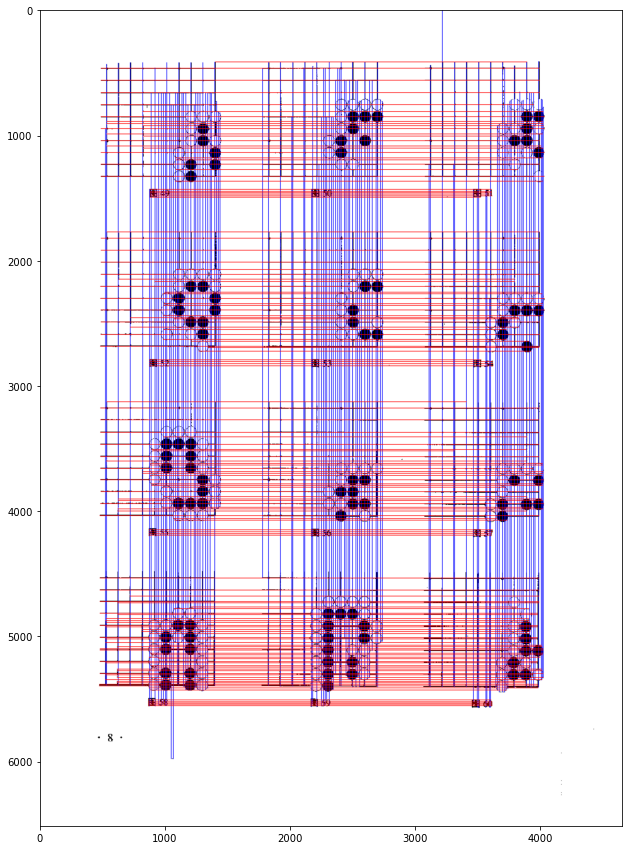

In [155]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
v_lines, h_lines =  get_verticals_horizontals(img_gray, 20)
img = cv2.imread(path, cv2.IMREAD_COLOR)[10:-10, 10:-10]
for line in v_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1-10, y1-10), (x2 - 10, y2 - 10), (255, 0, 0), 3)
for line in h_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1-10, y1-10), (x2-10, y2-10), (0, 0, 255), 3)
plt.imshow(to_RGB(img))
plt.show() 

In [156]:
def get_split_lines(lines, is_vertical):
    MIN_RATIO = 0.75
    
    if is_vertical:
        gaps = np.diff(lines[:, 0])
    else:
        gaps = np.diff(lines[:, 1])
    max_gap = np.amax(gaps)
    split_lines = []
    if is_vertical:
        split_line = lines[0] - [max_gap//2, 0, max_gap//2, 0]
    else:
        split_line = lines[0] - [0, max_gap//2, 0, max_gap//2]
    split_lines.append(split_line)
    if np.mean(gaps) / max_gap < MIN_RATIO:
        for i in range(gaps.shape[0]):
            if gaps[i]/max_gap >= MIN_RATIO:
                split_line = np.mean(lines[i:i+2], axis=0).astype(int)
                split_lines.append(split_line)
    if is_vertical:
        split_line = lines[-1] + [max_gap//2, 0, max_gap//2, 0]
    else:
        split_line = lines[-1] + [0, max_gap//2, 0, max_gap//2]
    split_lines.append(split_line)
    return np.array(split_lines)

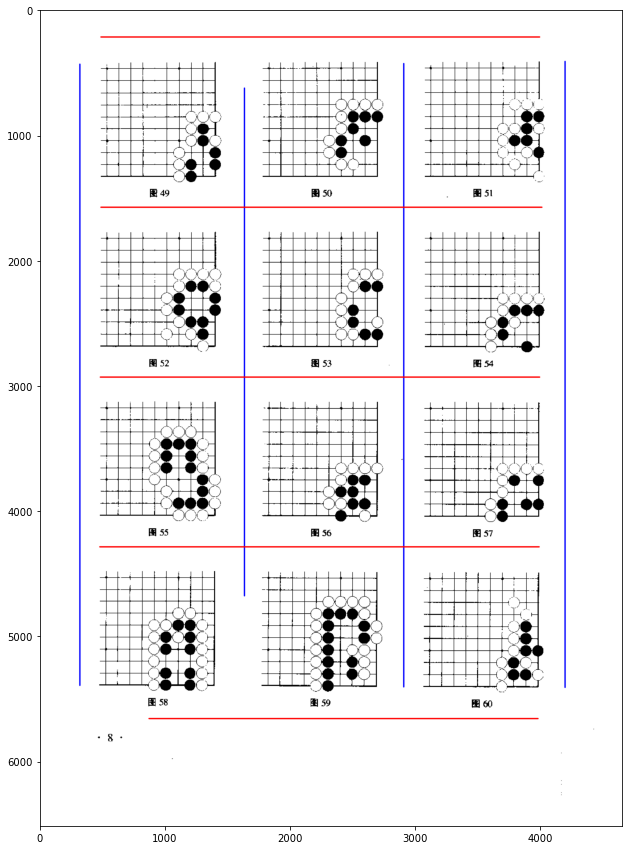

In [157]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)[10:-10, 10:-10]
v_lines, h_lines =  get_verticals_horizontals(img_gray, 200)
img = cv2.imread(path, cv2.IMREAD_COLOR)[10:-10, 10:-10]
v_lines = get_split_lines(v_lines, True)
h_lines = get_split_lines(h_lines, False)
for line in v_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 10)
for line in h_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 10)
plt.imshow(to_RGB(img))
plt.show() 

In [158]:
def find_intersections(v_lines, h_lines):
    return np.array(np.meshgrid(v_lines[:, 0], h_lines[:, 1])).T

In [159]:
def split_into_boards(page_img):
    
    HOUGH_THRESHOLD = 200

    page_img_gray = cv2.cvtColor(page_img, cv2.COLOR_BGR2GRAY)
    v_lines, h_lines = get_verticals_horizontals(page_img_gray[10:, 10:], HOUGH_THRESHOLD)
    v_lines = get_split_lines(v_lines, True)
    h_lines = get_split_lines(h_lines, False)
    intersections = find_intersections(v_lines, h_lines)
    board_images = []
    for i in range(intersections.shape[0] - 1):
        for j in range(intersections.shape[1] - 1):
            board_img = (page_img[intersections[i][j][1] + 10:intersections[i + 1][j + 1][1]+ 10,
                                  intersections[i][j][0] + 10:intersections[i + 1][j + 1][0]+ 10])
            board_images.append(board_img)
    return board_images

In [160]:
page_img = cv2.imread(path, cv2.IMREAD_COLOR)
boards = split_into_boards(page_img)

In [161]:
def visualize(img, r):
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(to_RGB(img))
        plt.axis('off')
        intersections, white_stones, black_stones, radius, x_size, y_size, edges = r.recognize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        
        
        for intersection in np.reshape(intersections, (-1, 2)):
            cv2.circle(img, (intersection[0], intersection[1]), 5, (255,0,255), -1)
            
        up_edge, down_edge, left_edge, right_edge = edges
        if up_edge:
            for intersection in intersections[:, 0]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if down_edge:
            for intersection in intersections[:, -1]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if left_edge:
            for intersection in intersections[0]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if right_edge:
            for intersection in intersections[-1]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        
            
        for stone in white_stones:
            cv2.circle(img ,(stone[0],stone[1]), radius,(0,0,255),3)
        for stone in black_stones:
            cv2.circle(img ,(stone[0],stone[1]), radius,(255,0,0),3)
        plt.subplot(1, 2, 2)
        plt.imshow(to_RGB(img))
        plt.axis('off')
        plt.show()

In [162]:
import sys  
sys.path.insert(0, './src')

In [163]:
import recognizer
r = recognizer.Recognizer()

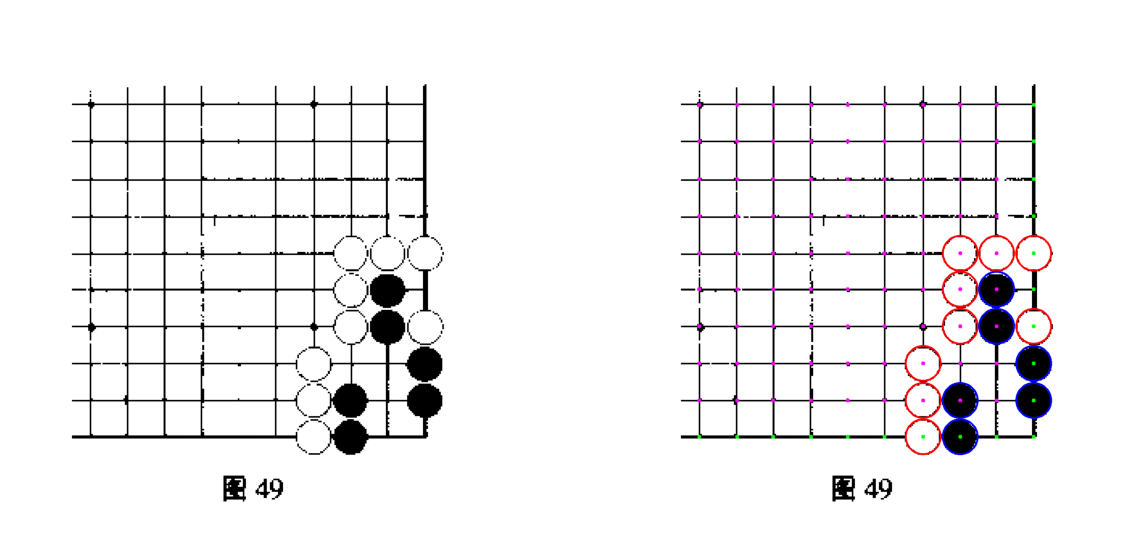

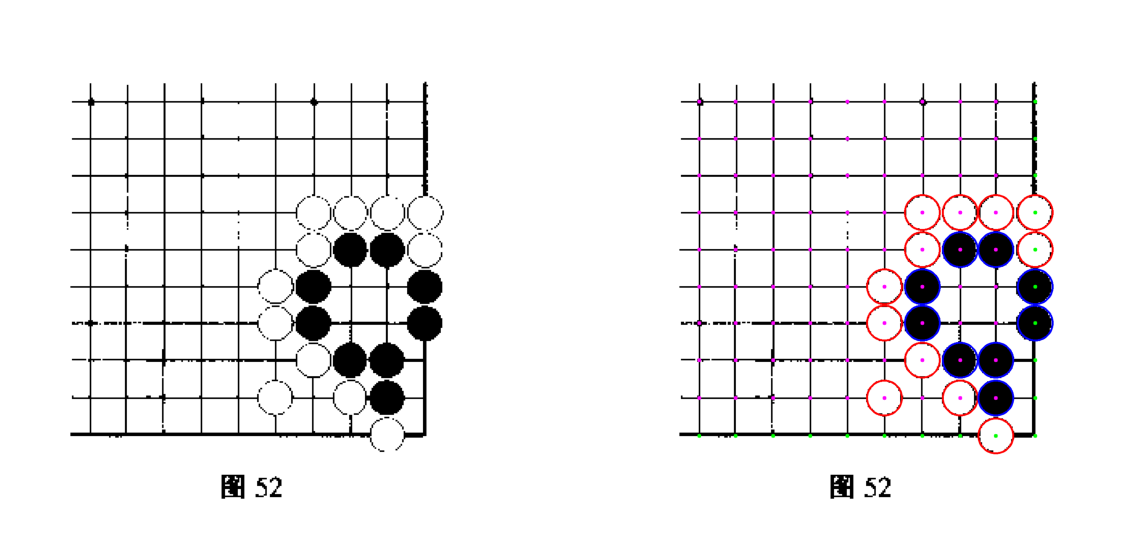

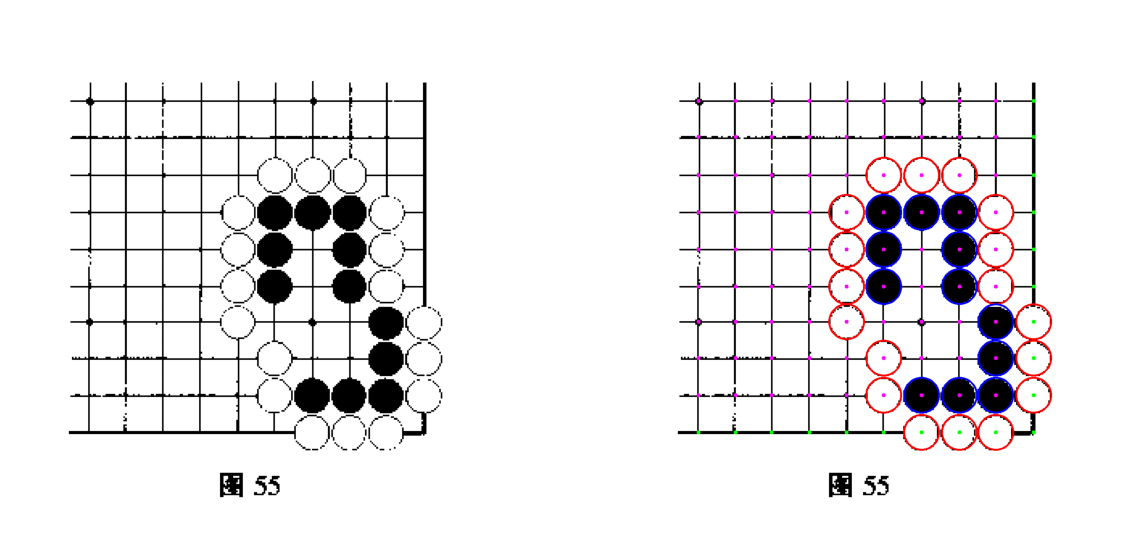

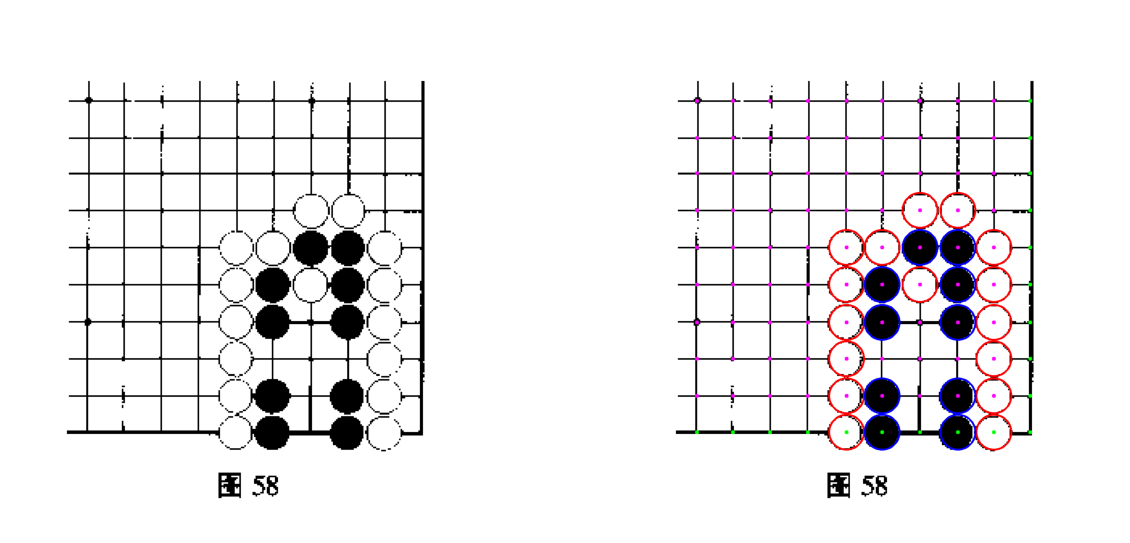

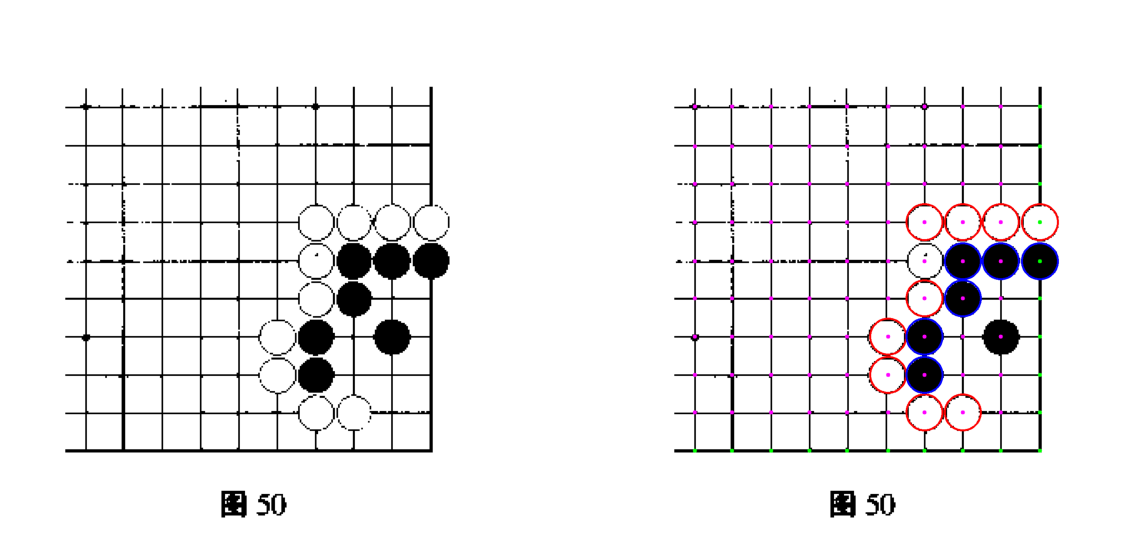

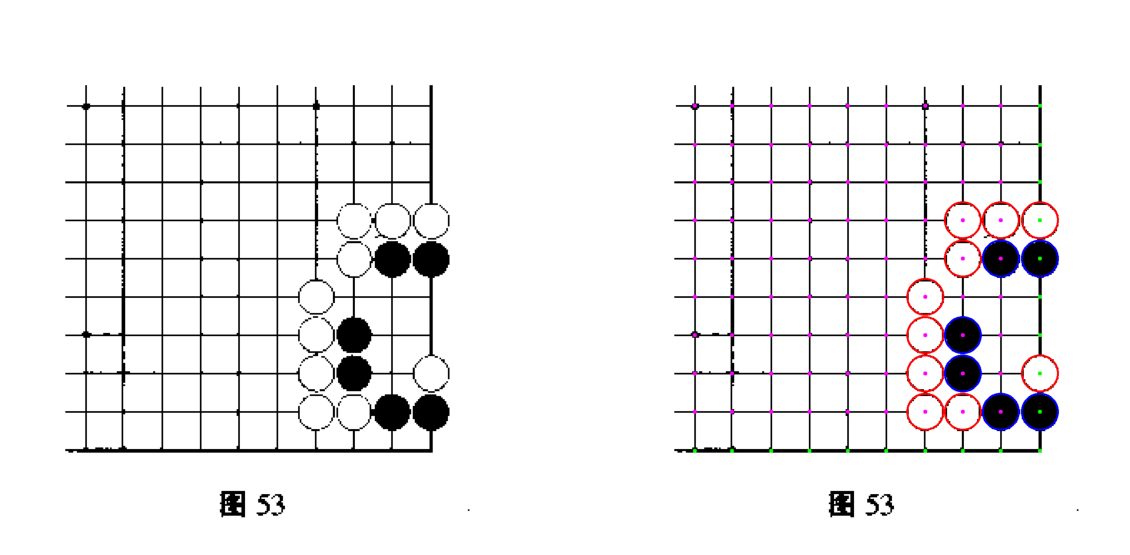

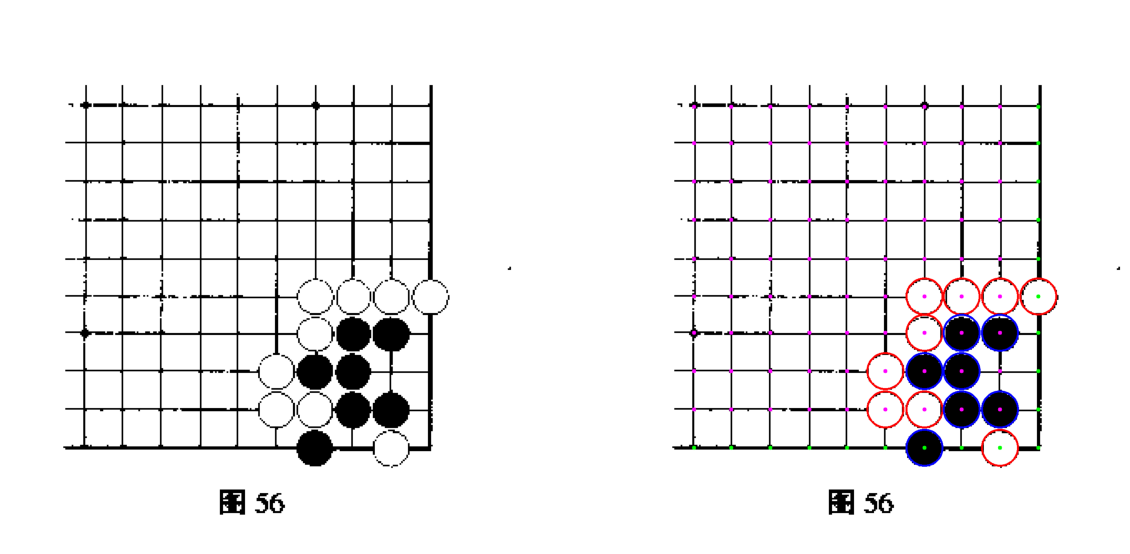

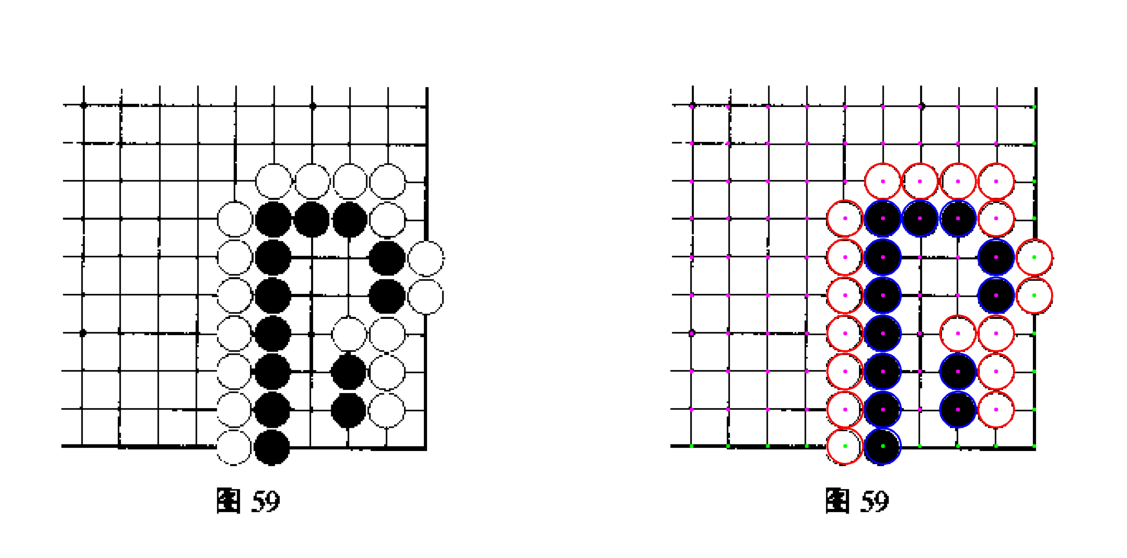

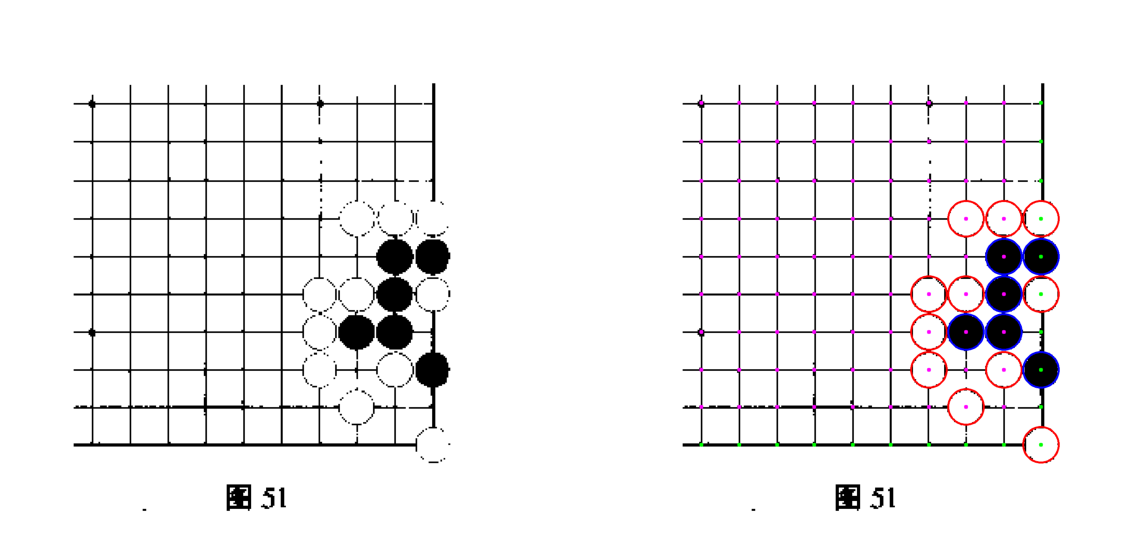

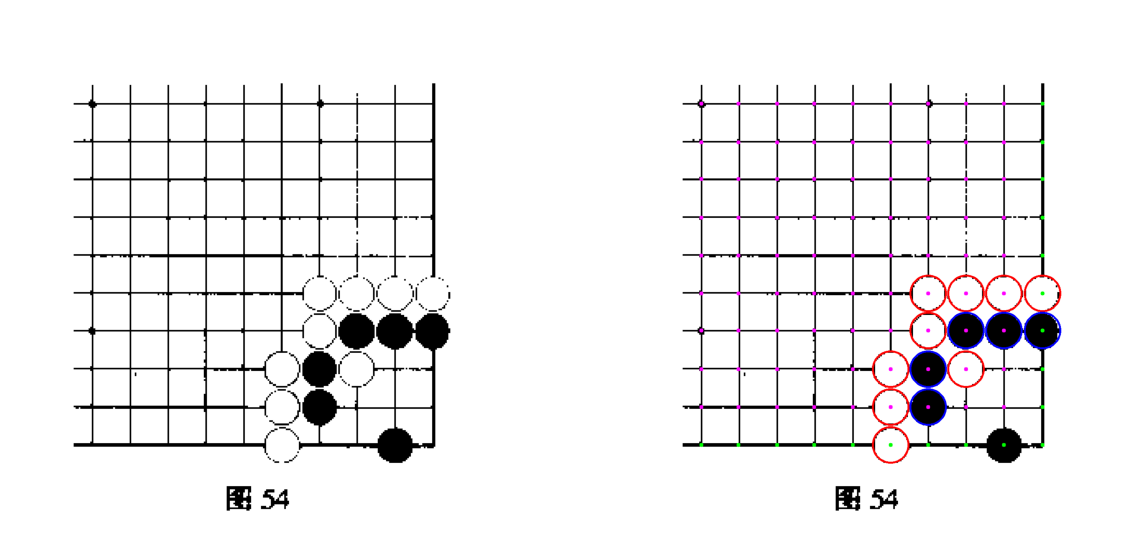

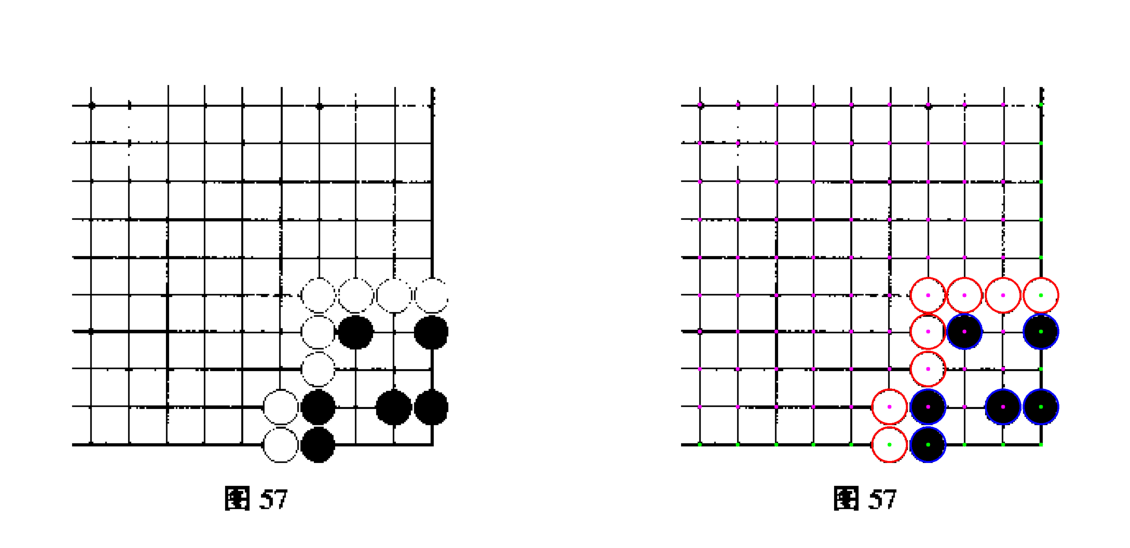

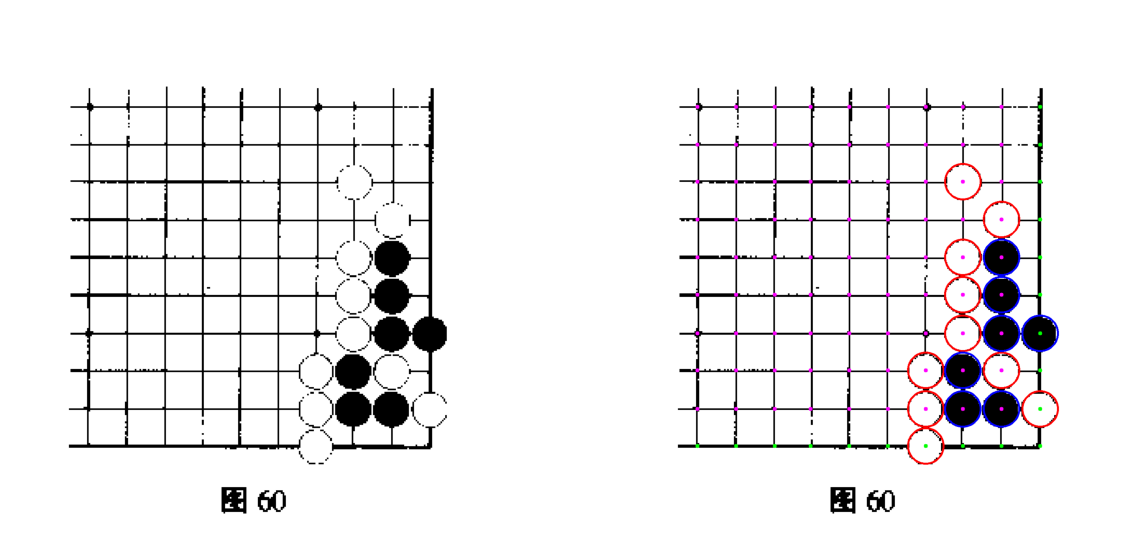

In [164]:
for i, board in enumerate(boards):
    visualize(board, r)
    #cv2.imwrite('k_{}.png'.format(i), board)

In [ ]:
boards.shape